In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))
x = torch.randn(1000, 1000).cuda()
y = torch.randn(1000, 1000).cuda()
z = torch.matmul(x, y)
print(z)


CUDA available: True
Device: NVIDIA GeForce RTX 4060 Laptop GPU
tensor([[-16.1705,  23.6367,   5.3579,  ..., -41.1281, -32.5805,  -8.8588],
        [-30.7042,   3.8764, -45.7880,  ...,   3.3034,   4.9988,   1.7415],
        [ -1.3914,  26.3847,  54.9717,  ..., -20.6860, -12.8206,  76.1624],
        ...,
        [-12.3214, -31.4915, -14.9265,  ..., -23.2738, -44.6632,  -6.8764],
        [-20.0098, -26.9023,   3.3084,  ...,   7.8488,  11.4869, -10.0794],
        [ -1.7920,  35.1412,  -7.3324,  ...,  -5.9756,  30.9356, -26.0133]],
       device='cuda:0')


In [2]:
!pip install librosa
!pip install numpy
!pip install matplotlib
!pip install python-osc
!pip install Pillow

In [3]:
import sys
import os
import torch
import librosa
print(librosa.__version__)
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)
import numpy as np
from torch import nn
from pythonosc.udp_client import SimpleUDPClient
from PIL import Image
import time
from pythonosc import udp_client
import numpy as np


0.10.2.post1
3.9.4


In [4]:
# Avoid recursion depth errors
#sys.setrecursionlimit(2000)

In [5]:
# Paths
audio_file_path = r"C:\Users\steph\OneDrive\Desktop\Audio Visualizer\Sample audio\EQed Audio.wav"
model_path = r"C:\AI\stylegan2-ada-main\ffhq.pkl"

In [6]:
# Ensure model file is downloaded
if not os.path.exists(model_path):
    print("Downloading StyleGAN2-ADA model weights...")
    import requests
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl'
    response = requests.get(url)
    with open(model_path, 'wb') as f:
        f.write(response.content)
    print("Model downloaded successfully.")
else:
    print("Model file already exists.")

Model file already exists.


In [7]:
# Process audio file
try:
    print("Loading audio file...")
    y, sr = librosa.load(audio_file_path, sr=22050)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    print("Audio file loaded successfully.")
except Exception as e:
    print(f"Error processing audio file: {e}")
    sys.exit(1)

Loading audio file...
Audio file loaded successfully.


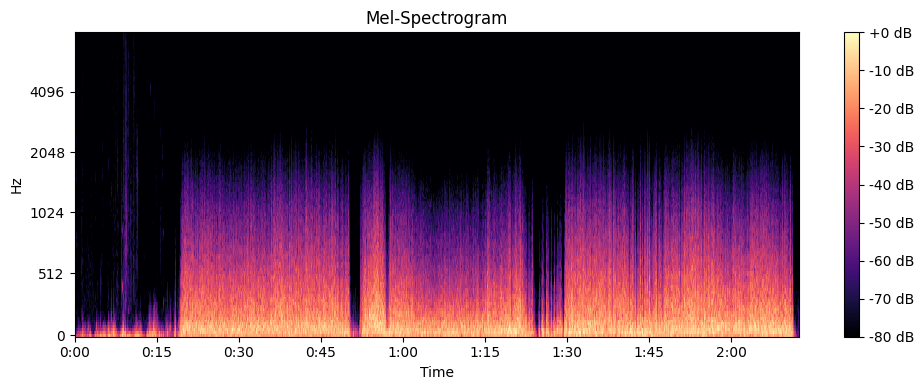

In [8]:
# Visualize Mel-Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

In [9]:
# Define Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            # Optional: Tanh to ensure latent is in [-1, 1] already
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)  # z is in [-1,1] if we ended with Tanh
        return z

In [10]:
# Instantiate VAE
try:
    latent_dim = 512
    hidden_dim = 1024
    # Flatten the mel-spectrogram for input
    input_dim = mel_spec_db.size
    
    # Create VAE and move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
    
    # Convert the mel-spectrogram to a PyTorch tensor (float32), batch dimension = 1
    mel_spec_flat = mel_spec_db.flatten().astype(np.float32)
    mel_spec_tensor = torch.tensor(mel_spec_flat).unsqueeze(0).to(device)
    
    # Pass through the encoder
    latent = vae(mel_spec_tensor)  # shape: [1, latent_dim]
    latent_vector = latent.detach().cpu().numpy().flatten()  # shape: [latent_dim]
    
    # Map from [-1,1] to [0,1]  (Option 2)
    latent_vector_mapped = (latent_vector + 1.0) / 2.0  
    # (Optional) clamp to ensure any numerical slight out-of-range is pinned to [0,1]
    latent_vector_mapped = np.clip(latent_vector_mapped, 0.0, 1.0)
    
    print("VAE processed successfully. Final latent shape:", latent_vector_mapped.shape)
except Exception as e:
    print(f"Error in VAE processing: {e}")
    sys.exit(1)

VAE processed successfully. Final latent shape: (512,)


In [ ]:
# This creates a UDP client that sends messages to TouchDesigner
# at IP address "127.0.0.1" (the same machine) on port 7000.
client = udp_client.SimpleUDPClient("127.0.0.1", 7000)

# current_vec is our "starting point" in 3D space (r, g, b).
# It’s chosen randomly between -1 and 1 for each coordinate.
# Default values set at (-1, 1, 3)
current_vec = np.random.uniform(-1, 1, 3)

while True:
    # new_vec is our "target point" that we'll interpolate toward.
    # Each time through the loop, we pick a new random 3D value.
    new_vec = np.random.uniform(-2, 2, 3)

    # The 'steps' variable decides how many in-between values
    # we calculate when transitioning from current_vec to new_vec.
    # Increase this if you want a smoother transition (more steps).
    # Decrease this if you want a faster, less smooth transition.
    # Default set at 50
    steps = 100  

    # We'll generate the intermediate values in a for-loop.
    for i in range(steps):
        # 't' goes from 0.0 up to 1.0 over the course of 'steps'.
        # This fraction (i / (steps - 1)) tells us how far along
        # the transition we are (0% to 100%).
        t = i / float(steps - 1)

        # This calculates the "in-between" vector for step i.
        # We're blending between current_vec and new_vec based on 't'.
        interpolated_vec = current_vec + (new_vec - current_vec) * t

        # We separate the 3D vector into individual values named r, g, b.
        r, g, b = interpolated_vec

        # Send these three values to TouchDesigner via OSC messages.
        # In TouchDesigner, you'll have three channels named r, g, b.
        client.send_message("/latent_vector/r", float(r))
        client.send_message("/latent_vector/g", float(g))
        client.send_message("/latent_vector/b", float(b))

        # This pause defines how long we wait between sending each
        # "in-between" value. A longer pause = slower changes.
        # For example, time.sleep(0.02) is 0.02 seconds or 20 ms.
        # That results in ~50 updates per second if steps=20.
        # Default set at 0.0001
        time.sleep(0.02) 

    # After we've sent all the in-between steps, we set current_vec
    # to the new_vec. That way, the next transition starts where
    # we left off.
    current_vec = new_vec
